# London Fire Incidents Dimensionality Reduction

In [1]:
%matplotlib inline 
import os
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

### Downloading and loading the data

In [2]:
# Loading the data
# import data_download #This module has to be loaded to download the data automatically

LFB_data = pd.read_excel(os.path.join("LFB-data","LFB Incident data Last 3 years.xlsx"))
# LFB_data = pd.read_excel("/content/drive/MyDrive/LFB_Incident_data_Last_3_years.xlsx")
LFB_data.head()

IncidentNumber   DateOfCall  CalYear TimeOfCall  HourOfCall  \
0  000006-01012019  01 Jan 2019     2019   00:01:45           0   
1  000019-01012019  01 Jan 2019     2019   00:04:33           0   
2  000020-01012019  01 Jan 2019     2019   00:04:39           0   
3  000021-01012019  01 Jan 2019     2019   00:04:44           0   
4  000024-01012019  01 Jan 2019     2019   00:05:00           0   

     IncidentGroup        StopCodeDescription SpecialServiceType  \
0  Special Service            Special Service       Lift Release   
1             Fire             Secondary Fire                NaN   
2      False Alarm  False alarm - Good intent                NaN   
3      False Alarm                        AFA                NaN   
4  Special Service            Special Service       Lift Release   

  PropertyCategory                                       PropertyType  ...  \
0         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys   ...   
1          Outdoor                                        Tree scrub   ...   
2          Outdoor        Domestic garden (vegetation not equipment)   ...   
3         Dwelling             Stately Home (part not open to public)  ...   
4         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys   ...   

  FirstPumpArriving_AttendanceTime FirstPumpArriving_DeployedFromStation  \
0                              NaN                                   NaN   
1                            357.0                              Edmonton   
2                            318.0                             Southgate   
3                            210.0                            Kensington   
4                            329.0                         Bethnal Green   

  SecondPumpArriving_AttendanceTime  SecondPumpArriving_DeployedFromStation  \
0                               NaN                                     NaN   
1                               NaN                                     NaN   
2                               NaN                                     NaN   
3                               NaN                                     NaN   
4                               NaN                                     NaN   

   NumStationsWithPumpsAttending NumPumpsAttending PumpCount PumpHoursRoundUp  \
0                            1.0               1.0       1.0              1.0   
1                            1.0               1.0       1.0              1.0   
2                            1.0               1.0       1.0              1.0   
3                            1.0               1.0       1.0              1.0   
4                            1.0               1.0       1.0              1.0   

  Notional Cost (£) NumCalls  
0             333.0      2.0  
1             333.0      1.0  
2             333.0      1.0  
3             333.0      1.0  
4             333.0      1.0  

[5 rows x 39 columns]

### creating a random sample to work with

In [3]:
random.seed(10)
rand_num=random.sample(range(len(LFB_data)), 10000)
rand_num[:10]

[299579, 17083, 224861, 253001, 303086, 7776, 108054, 242525, 257580, 145500]

In [4]:
df = LFB_data.iloc[rand_num]
df.shape

(10000, 39)

In [5]:
# Delete the LFB-data dataframe from memory
del LFB_data

In [6]:
# %pip install plotly
import plotly.express as px

print("Zoom out the map")
fig = px.density_mapbox(df, lat='Latitude', lon='Longitude', radius=10,
                       center = dict(lat = 50, lon= 0.5), zoom=3,
                       mapbox_style='stamen-terrain')
fig.show()

Zoom out the map


## Data Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 299579 to 385579
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   IncidentNumber                          10000 non-null  object 
 1   DateOfCall                              10000 non-null  object 
 2   CalYear                                 10000 non-null  int64  
 3   TimeOfCall                              10000 non-null  object 
 4   HourOfCall                              10000 non-null  int64  
 5   IncidentGroup                           10000 non-null  object 
 6   StopCodeDescription                     10000 non-null  object 
 7   SpecialServiceType                      3449 non-null   object 
 8   PropertyCategory                        10000 non-null  object 
 9   PropertyType                            10000 non-null  object 
 10  AddressQualifier                        10000 non-nu

#### Time Processing

In [8]:
# We need to drop the existing Hour of call and create our own
df.drop('HourOfCall', axis=1, inplace=True)

# Create a new column from the DateOfCall column.
df['YearOfCall'], df['MonthOfCall'] = df['DateOfCall'].apply(lambda x: x.split(" ")[2]),df['DateOfCall'].apply(lambda x: x.split(" ")[1])
df['HourOfCall'] = df['TimeOfCall'].apply(lambda x: x.split(":")[0])

# Dropping unnecessary time columns
df.drop(['IncidentNumber','TimeOfCall','DateOfCall','CalYear'], axis=1, inplace = True)

#### Service and group processing

In [9]:
# We need to turn the incident group into ordinal encoding

# We convert the column from object to a category 
# df['IncidentGroup'] = df['IncidentGroup'].astype('category')
# df['IncidentGroup'] = df['IncidentGroup'].cat.codes # False alarm = 0, Fire = 1, special service = 2

# Drop the columns
df.drop(['StopCodeDescription','SpecialServiceType'], axis=1, inplace = True)
df.sample(4)

IncidentGroup PropertyCategory  \
365709  Special Service         Dwelling   
353514      False Alarm  Non Residential   
153248      False Alarm         Dwelling   
53748   Special Service         Dwelling   

                                             PropertyType  \
365709  Purpose Built Flats/Maisonettes - Up to 3 stor...   
353514                                 Telephone exchange   
153248                          House - single occupancy    
53748        Converted Flat/Maisonette - Up to 2 storeys    

                 AddressQualifier Postcode_full Postcode_district  \
365709  Correct incident location           NaN               RM6   
353514  Correct incident location       HA7 4AX               HA7   
153248  Correct incident location           NaN               TW9   
53748   Correct incident location           NaN              NW10   

               UPRN      USRN IncGeo_BoroughCode    IncGeo_BoroughName  ...  \
365709            0  19900135          E09000002  BARKING AND DAGENHAM  ...   
353514  10000001110  21202202          E09000015                HARROW  ...   
153248            0  22405839          E09000027  RICHMOND UPON THAMES  ...   
53748             0  20200310          E09000005                 BRENT  ...   

       SecondPumpArriving_DeployedFromStation NumStationsWithPumpsAttending  \
365709                                    NaN                           1.0   
353514                                    NaN                           1.0   
153248                               Chiswick                           2.0   
53748                                     NaN                           1.0   

       NumPumpsAttending PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
365709               1.0       1.0               1.0              364.0   
353514               1.0       1.0               1.0              364.0   
153248               2.0       2.0               1.0              346.0   
53748                1.0       1.0               1.0              339.0   

        NumCalls  YearOfCall  MonthOfCall  HourOfCall  
365709       2.0        2022          Jun          10  
353514       1.0        2022          May          06  
153248       1.0        2020          Jul          21  
53748        1.0        2019          Jul          20  

[4 rows x 35 columns]

#### Inc Geo data

In [10]:
# Inc Geo borough name and code all describe the same borough. 

# Number of distinct rows for each column
print(df[['IncGeo_BoroughCode', 'IncGeo_BoroughName']].nunique())

IncGeo_BoroughCode    33
IncGeo_BoroughName    33
dtype: int64


In [11]:
# we can join the two columns into one to avoid to many vatiables after encoding
df['IncGeo_Borough'] = df['IncGeo_BoroughCode'] + '-' +df['IncGeo_BoroughName']

# Finally we need to drop the two columns
df.drop(['IncGeo_BoroughCode','IncGeo_BoroughName'], axis=1, inplace=True)
df['IncGeo_Borough'].tail(3)

329584     E09000003-BARNET
27241     E09000010-ENFIELD
385579     E09000009-EALING
Name: IncGeo_Borough, dtype: object

In [12]:
# Similary for IncGeo code, ward name and ward name new, all describe the same ward

# Number of distinct rows for each column
print(df[['IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew']].nunique())
df['IncGeo_Ward'] = df['IncGeo_WardCode'] + '-' +df['IncGeo_WardName']

# Drop Unecessary Columns
df.drop(['IncGeo_WardCode','IncGeo_WardName','IncGeo_WardNameNew'], axis=1, inplace=True)
df['IncGeo_Ward'].sample(3)

IncGeo_WardCode        706
IncGeo_WardName       1132
IncGeo_WardNameNew    1132
dtype: int64


171596    E05009317-Bethnal Green
342127         E05013580-Uxbridge
344395       E05014064-Longbridge
Name: IncGeo_Ward, dtype: object

#### Slicing Northing_m and easting_m to 4 last digits

In [13]:
# process Northing and easting data and process it ito categorical data using pandas cut

df['Easting_rounded']= df['Easting_rounded'].apply(lambda x: int(str(x)[2:]))
# df['Easting_rounded']= pd.cut(df['Easting_rounded'], bins=10, labels=['Easting_rounded_0','Easting_rounded_1','Easting_rounded_2','Easting_rounded_3','Easting_rounded_4','Easting_rounded_5','Easting_rounded_6','Easting_rounded_7','Easting_rounded_8','Easting_rounded_9'])

df['Northing_rounded']= df['Northing_rounded'].apply(lambda x: int(str(x)[2:]))
# df['Northing_rounded']= pd.cut(df['Northing_rounded'], bins=10, labels=['Northing_rounded_0','Northing_rounded_1','Northing_rounded_2','Northing_rounded_3','Northing_rounded_4','Northing_rounded_5','Northing_rounded_6','Northing_rounded_7','Northing_rounded_8','Northing_rounded_9'])

In [14]:
df.nunique()

IncidentGroup                                3
PropertyCategory                             9
PropertyType                               223
AddressQualifier                            11
Postcode_full                             4067
Postcode_district                          283
UPRN                                      4309
USRN                                      6783
ProperCase                                  33
Easting_m                                 4166
Northing_m                                4083
Easting_rounded                            100
Northing_rounded                           100
Latitude                                  4484
Longitude                                 4485
FRS                                          1
IncidentStationGround                      102
FirstPumpArriving_AttendanceTime           751
FirstPumpArriving_DeployedFromStation      102
SecondPumpArriving_AttendanceTime          649
SecondPumpArriving_DeployedFromStation     100
NumStationsWi

In [15]:
grouping_labels = df['IncidentGroup']

#### Dropping Unecessary columns

In [16]:
df.drop(['IncidentGroup','Postcode_full','SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation'], axis=1,inplace=True)

## Exploratory data analysis

### Numerical data

In [17]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])

print("Numeric data shape : ",df_numeric.shape)
df_numeric.columns.values

Numeric data shape :  (10000, 15)


array(['UPRN', 'USRN', 'Easting_m', 'Northing_m', 'Easting_rounded',
       'Northing_rounded', 'Latitude', 'Longitude',
       'FirstPumpArriving_AttendanceTime',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls'], dtype=object)

In [18]:
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

count            mean             std  \
UPRN                              10000.00  20048017318.45  45175754090.93   
USRN                              10000.00     20352101.09      3922045.92   
Easting_m                          4533.00       530579.90        10545.63   
Northing_m                         4533.00       180522.59         7604.20   
Easting_rounded                   10000.00         4942.88         2861.35   
Northing_rounded                  10000.00         4907.37         2947.31   
Latitude                           4533.00           51.28            3.41   
Longitude                          4533.00           -0.12            0.15   
FirstPumpArriving_AttendanceTime   9388.00          309.82          129.30   
NumStationsWithPumpsAttending      9863.00            1.39            0.77   
NumPumpsAttending                  9863.00            1.55            0.90   
PumpCount                          9937.00            1.60            1.28   
PumpHoursRoundUp                   9935.00            1.36            3.92   
Notional Cost (£)                  9935.00          472.94         1346.68   
NumCalls                          10000.00            1.30            1.26   

                                         min          25%          50%  \
UPRN                                    0.00         0.00         0.00   
USRN                              8100027.00  20401328.25  21201439.00   
Easting_m                          504092.00    524846.00    530889.00   
Northing_m                         157513.00    175974.00    181069.00   
Easting_rounded                        50.00      2550.00      4850.00   
Northing_rounded                       50.00      2250.00      4850.00   
Latitude                                0.00        51.47        51.51   
Longitude                              -0.50        -0.20        -0.12   
FirstPumpArriving_AttendanceTime        2.00       229.00       292.00   
NumStationsWithPumpsAttending           1.00         1.00         1.00   
NumPumpsAttending                       1.00         1.00         1.00   
PumpCount                               1.00         1.00         1.00   
PumpHoursRoundUp                        1.00         1.00         1.00   
Notional Cost (£)                     333.00       339.00       352.00   
NumCalls                                1.00         1.00         1.00   

                                             75%              max  
UPRN                              10013270924.50  200004439224.00  
USRN                                 22101984.50      99990078.00  
Easting_m                              536907.00        559259.00  
Northing_m                             185379.00        200220.00  
Easting_rounded                          7350.00          9950.00  
Northing_rounded                         7650.00          9950.00  
Latitude                                   51.55            51.69  
Longitude                                  -0.03             0.30  
FirstPumpArriving_AttendanceTime          370.00          1171.00  
NumStationsWithPumpsAttending               2.00             8.00  
NumPumpsAttending                           2.00             8.00  
PumpCount                                   2.00            55.00  
PumpHoursRoundUp                            1.00           263.00  
Notional Cost (£)                         364.00         87579.00  
NumCalls                                    1.00            40.00

We can tell from the data above that there are outliers in the numeric data.
For instance, there are values that have a very huge diffrence between the 75th percentile and maximum value

#### Numerical data visualization

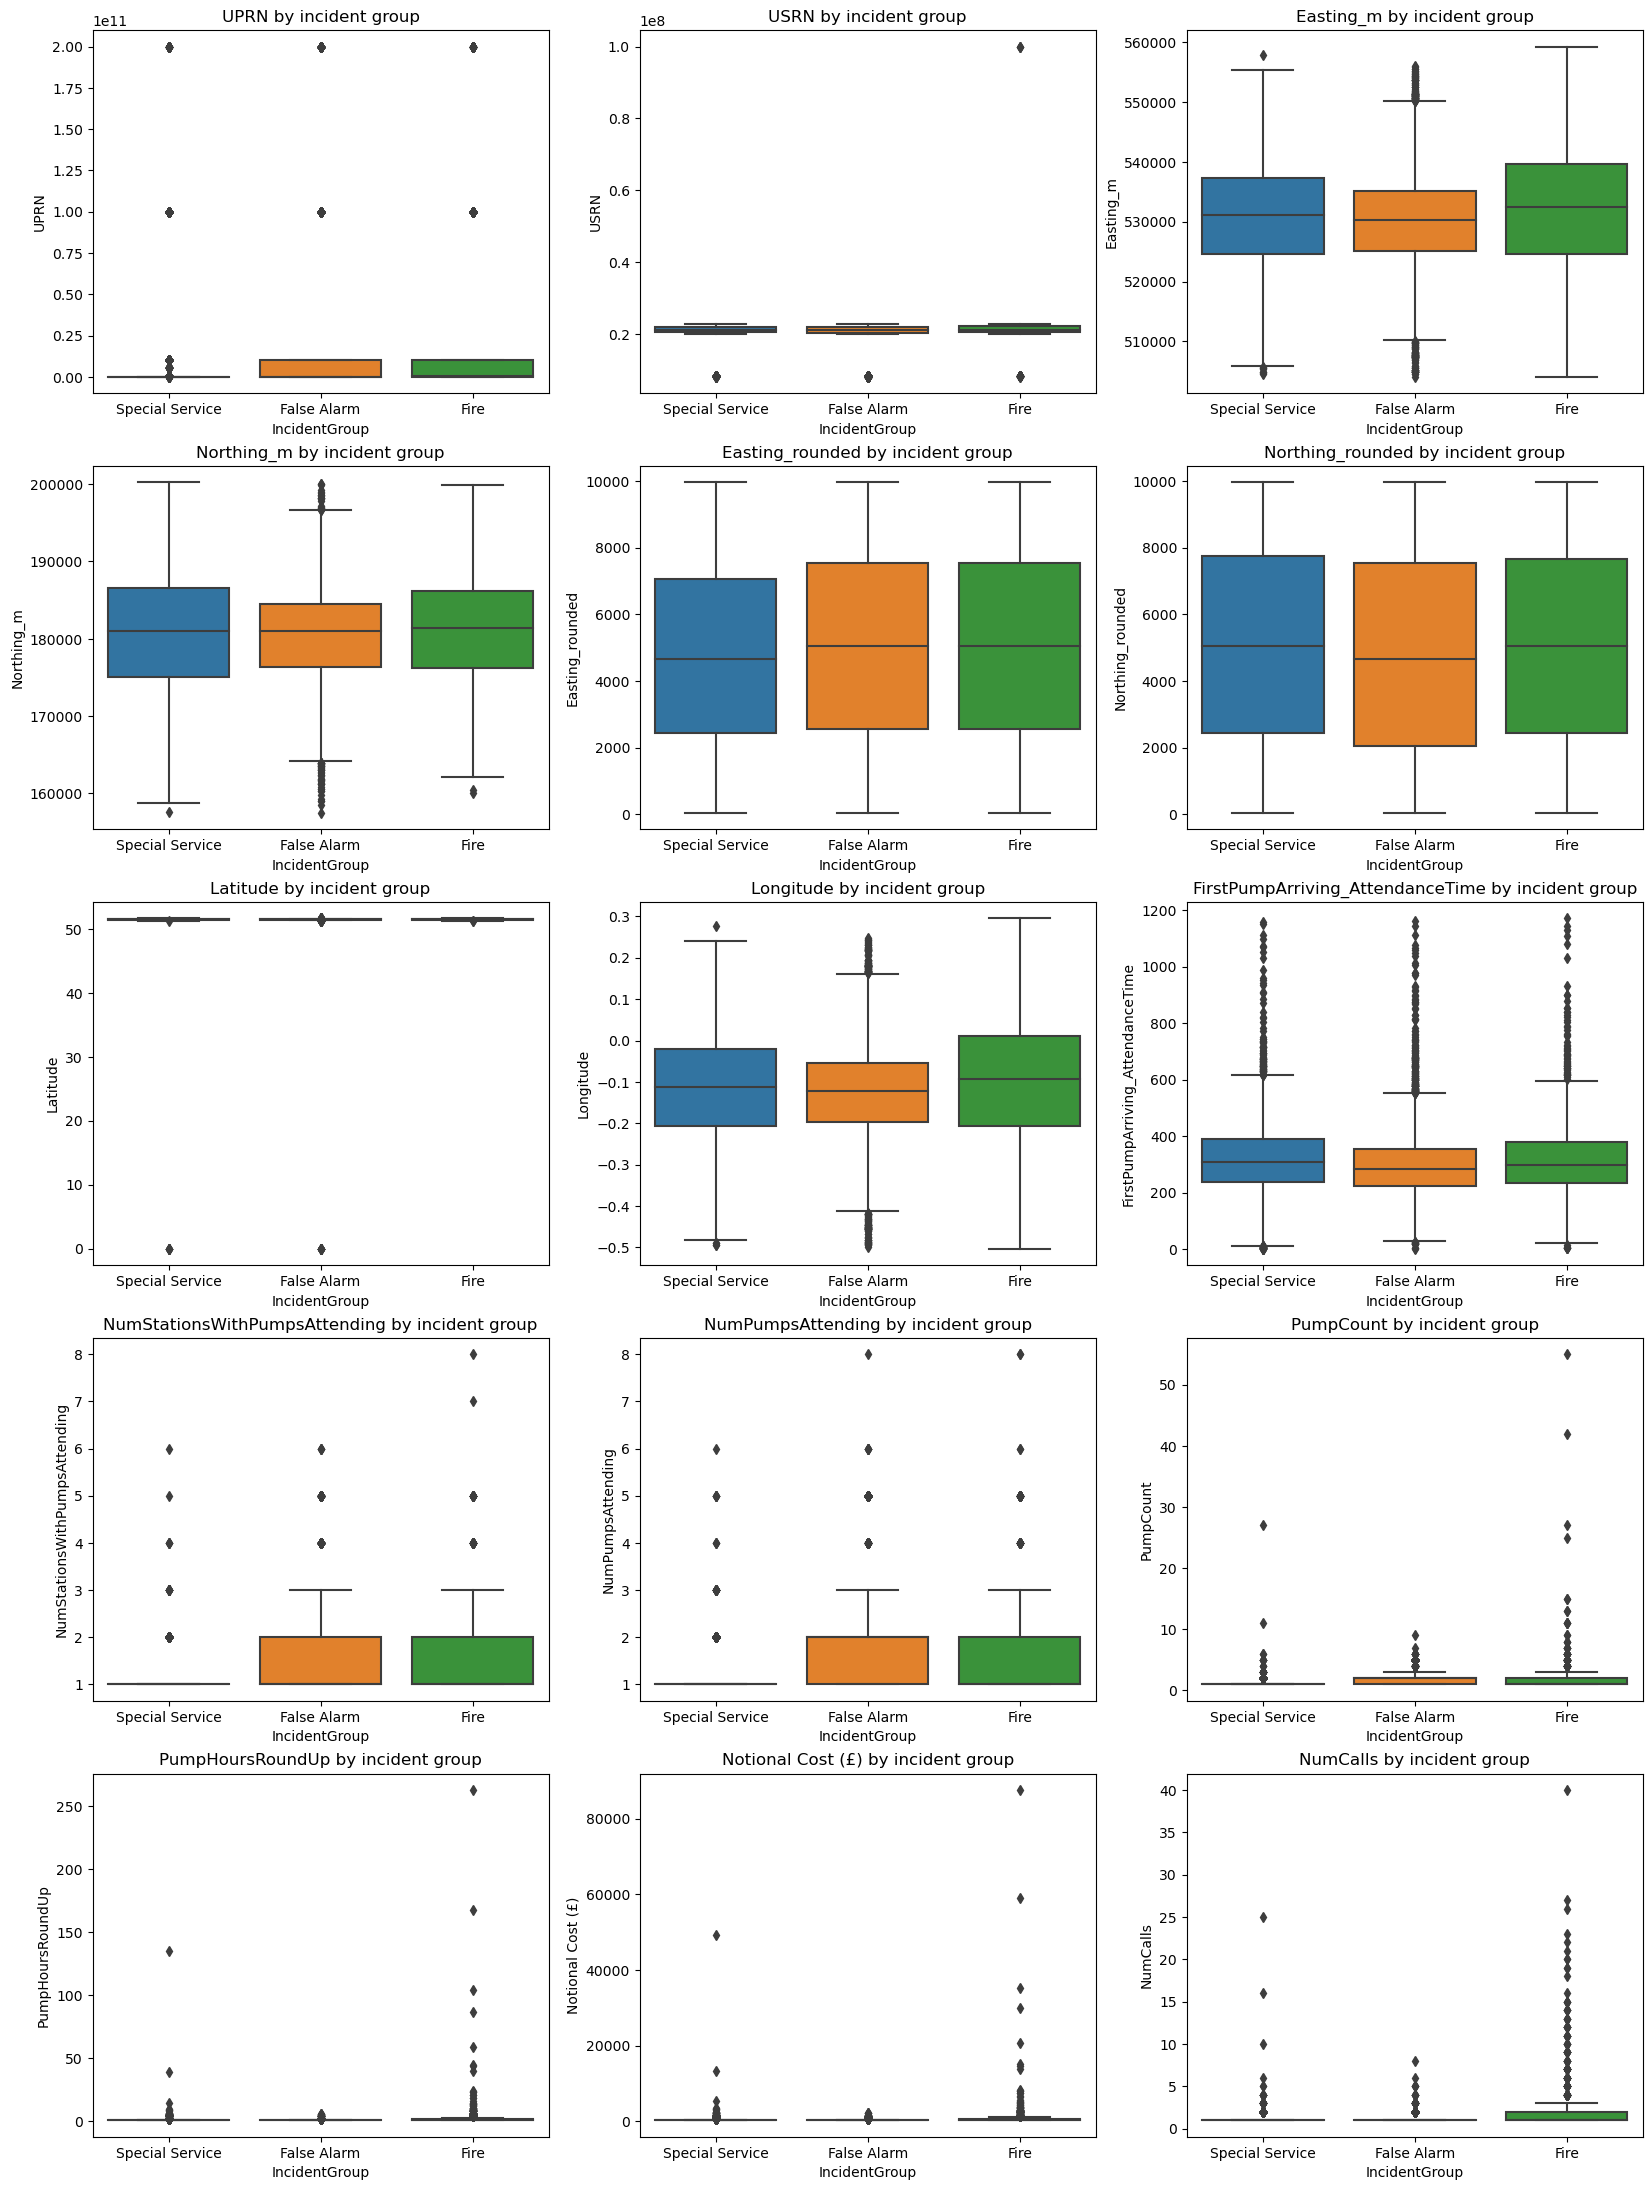

In [19]:
fig = plt.figure(figsize= (20,50))

for i in range(len(df_numeric.columns)):
    column = df_numeric.columns[i]
    sub = fig.add_subplot(9,3, i+1)
    chart = sns.boxplot(data=df_numeric, y=column, x = grouping_labels)
    chart.set_title(column + " by incident group")

#### Missing values on Numeric data

In [20]:
# Check for any missing values
print("Number of cols with Missing Vals: ",df_numeric.isna().any().sum())
display(df_numeric.isna().sum())

Number of cols with Missing Vals:  10


UPRN                                   0
USRN                                   0
Easting_m                           5467
Northing_m                          5467
Easting_rounded                        0
Northing_rounded                       0
Latitude                            5467
Longitude                           5467
FirstPumpArriving_AttendanceTime     612
NumStationsWithPumpsAttending        137
NumPumpsAttending                    137
PumpCount                             63
PumpHoursRoundUp                      65
Notional Cost (£)                     65
NumCalls                               0
dtype: int64

<h6>We need to fix the missing values to cluster around the mean value<br>We will consider randomizing the missing values between 30% and 70%</h6>

#### Missing values

In [21]:

# for i in df_numeric[['UPRN', 'USRN', 'Easting_m', 'Northing_m','Easting_rounded', 'Northing_rounded',
#                     'FirstPumpArriving_AttendanceTime','SecondPumpArriving_AttendanceTime',
#                     'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
#                     'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls']]:
for i in df_numeric.columns.values:
    df_numeric.fillna(0, inplace=True)
    # Set 30 and 70th percentile and round off to 2
    rand_30_70 = random.uniform(round(np.percentile(df_numeric[i],30),2), round(np.percentile(df_numeric[i],70),2)) 
    for j in i:
        if j == 0:
            df_numeric.replace(to_replace=0, value=rand_30_70, inplace=True)
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Easting_rounded                     0
Northing_rounded                    0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

In [22]:
df_numeric.describe()

UPRN          USRN      Easting_m     Northing_m  \
count  1.000000e+04  1.000000e+04   10000.000000   10000.000000   
mean   2.004802e+10  2.035210e+07  240511.870700   81830.889800   
std    4.517575e+10  3.922046e+06  264238.884672   90016.918874   
min    0.000000e+00  8.100027e+06       0.000000       0.000000   
25%    0.000000e+00  2.040133e+07       0.000000       0.000000   
50%    0.000000e+00  2.120144e+07       0.000000       0.000000   
75%    1.001327e+10  2.210198e+07  529967.250000  180549.000000   
max    2.000044e+11  9.999008e+07  559259.000000  200220.000000   

       Easting_rounded  Northing_rounded      Latitude     Longitude  \
count     10000.000000       10000.00000  10000.000000  10000.000000   
mean       4942.880000        4907.37000     23.245792     -0.054001   
std        2861.354931        2947.30934     25.633126      0.118123   
min          50.000000          50.00000      0.000000     -0.502520   
25%        2550.000000        2250.00000      0.000000     -0.102301   
50%        4850.000000        4850.00000      0.000000      0.000000   
75%        7350.000000        7650.00000     51.509022      0.000000   
max        9950.000000        9950.00000     51.685586      0.295251   

       FirstPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  \
count                      10000.000000                   10000.000000   
mean                         290.855600                       1.374900   
std                          145.638303                       0.777438   
min                            0.000000                       0.000000   
25%                          215.000000                       1.000000   
50%                          284.000000                       1.000000   
75%                          363.000000                       2.000000   
max                         1171.000000                       8.000000   

       NumPumpsAttending    PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
count       10000.000000  10000.00000      10000.000000        10000.00000   
mean            1.527700      1.58630          1.348800          469.86270   
std             0.915159      1.28379          3.912629         1342.83802   
min             0.000000      0.00000          0.000000            0.00000   
25%             1.000000      1.00000          1.000000          339.00000   
50%             1.000000      1.00000          1.000000          352.00000   
75%             2.000000      2.00000          1.000000          364.00000   
max             8.000000     55.00000        263.000000        87579.00000   

           NumCalls  
count  10000.000000  
mean       1.304200  
std        1.263021  
min        1.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max       40.000000

#### Outliers in numerical data

In [23]:
for i in df_numeric.columns:
    df_numeric.fillna(df_numeric[i].mode()[0], inplace = True)
    highest_val = df_numeric[i].mean() + 3*df_numeric[i].std()
    lowest_val = df_numeric[i].mean() - 3*df_numeric[i].std()
    print(f"Range for {i} : ", round(lowest_val,2), " to ",round(highest_val,2))
    
#     Trimming the outliers
    df_numeric[i]= np.where(df_numeric[i]>highest_val, highest_val,
                           np.where(df_numeric[i]<lowest_val, lowest_val,
                                   df_numeric[i]))
#     (df_numeric[i]>=lowest_val)&(df_numeric[i]<=highest_val)

print( "\n","*"*120)
df_numeric.describe().T.apply(lambda s: s.apply('{0:.2f}'.format))

Range for UPRN :  -115479244954.33  to  155575279591.24
Range for USRN :  8585963.33  to  32118238.84
Range for Easting_m :  -552204.78  to  1033228.52
Range for Northing_m :  -188219.87  to  351881.65
Range for Easting_rounded :  -3641.18  to  13526.94
Range for Northing_rounded :  -3934.56  to  13749.3
Range for Latitude :  -53.65  to  100.15
Range for Longitude :  -0.41  to  0.3
Range for FirstPumpArriving_AttendanceTime :  -146.06  to  727.77
Range for NumStationsWithPumpsAttending :  -0.96  to  3.71
Range for NumPumpsAttending :  -1.22  to  4.27
Range for PumpCount :  -2.27  to  5.44
Range for PumpHoursRoundUp :  -10.39  to  13.09
Range for Notional Cost (£) :  -3558.65  to  4498.38
Range for NumCalls :  -2.48  to  5.09

 ************************************************************************************************************************


count            mean             std  \
UPRN                              10000.00  18786289158.23  40511292836.86   
USRN                              10000.00     20349556.23      3619007.68   
Easting_m                         10000.00       240511.87       264238.88   
Northing_m                        10000.00        81830.89        90016.92   
Easting_rounded                   10000.00         4942.88         2861.35   
Northing_rounded                  10000.00         4907.37         2947.31   
Latitude                          10000.00           23.25           25.63   
Longitude                         10000.00           -0.05            0.12   
FirstPumpArriving_AttendanceTime  10000.00          289.20          138.99   
NumStationsWithPumpsAttending     10000.00            1.35            0.68   
NumPumpsAttending                 10000.00            1.50            0.81   
PumpCount                         10000.00            1.56            0.94   
PumpHoursRoundUp                  10000.00            1.26            1.01   
Notional Cost (£)                 10000.00          437.82          351.81   
NumCalls                          10000.00            1.24            0.66   

                                         min          25%          50%  \
UPRN                                    0.00         0.00         0.00   
USRN                              8585963.33  20401328.25  21201439.00   
Easting_m                               0.00         0.00         0.00   
Northing_m                              0.00         0.00         0.00   
Easting_rounded                        50.00      2550.00      4850.00   
Northing_rounded                       50.00      2250.00      4850.00   
Latitude                                0.00         0.00         0.00   
Longitude                              -0.41        -0.10         0.00   
FirstPumpArriving_AttendanceTime        0.00       215.00       284.00   
NumStationsWithPumpsAttending           0.00         1.00         1.00   
NumPumpsAttending                       0.00         1.00         1.00   
PumpCount                               0.00         1.00         1.00   
PumpHoursRoundUp                        0.00         1.00         1.00   
Notional Cost (£)                       0.00       339.00       352.00   
NumCalls                                1.00         1.00         1.00   

                                             75%              max  
UPRN                              10013270924.50  155575279591.24  
USRN                                 22101984.50      32118238.84  
Easting_m                              529967.25        559259.00  
Northing_m                             180549.00        200220.00  
Easting_rounded                          7350.00          9950.00  
Northing_rounded                         7650.00          9950.00  
Latitude                                   51.51            51.69  
Longitude                                   0.00             0.30  
FirstPumpArriving_AttendanceTime          363.00           727.77  
NumStationsWithPumpsAttending               2.00             3.71  
NumPumpsAttending                           2.00             4.27  
PumpCount                                   2.00             5.44  
PumpHoursRoundUp                            1.00            13.09  
Notional Cost (£)                         364.00          4498.38  
NumCalls                                    1.00             5.09

In [24]:
df_numeric.isnull().sum()

UPRN                                0
USRN                                0
Easting_m                           0
Northing_m                          0
Easting_rounded                     0
Northing_rounded                    0
Latitude                            0
Longitude                           0
FirstPumpArriving_AttendanceTime    0
NumStationsWithPumpsAttending       0
NumPumpsAttending                   0
PumpCount                           0
PumpHoursRoundUp                    0
Notional Cost (£)                   0
NumCalls                            0
dtype: int64

### Categorical Data

In [25]:
df_categorical = df.select_dtypes(exclude=[np.number])
print(df_categorical.shape)
print( "\n","-"*120)
df_categorical.columns.values

(10000, 13)

 ------------------------------------------------------------------------------------------------------------------------


array(['PropertyCategory', 'PropertyType', 'AddressQualifier',
       'Postcode_district', 'ProperCase', 'FRS', 'IncidentStationGround',
       'FirstPumpArriving_DeployedFromStation', 'YearOfCall',
       'MonthOfCall', 'HourOfCall', 'IncGeo_Borough', 'IncGeo_Ward'],
      dtype=object)

In [26]:
df_categorical.sample(10)

PropertyCategory                                       PropertyType  \
394881           Dwelling                          House - single occupancy    
256150       Road Vehicle                                 Multiple Vehicles    
189358           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
145256            Outdoor                                      Loose refuse    
374890  Outdoor Structure                     Small refuse/rubbish container   
198834           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
131986           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
340832           Dwelling                          House - single occupancy    
49016            Dwelling                          House - single occupancy    
357557    Non Residential                                  Pub/wine bar/bar    

                            AddressQualifier Postcode_district  \
394881                  Within same building               CR0   
256150  In street outside gazetteer location               TW4   
189358             Correct incident location                E8   
145256      On land associated with building               N16   
374890             Correct incident location              SE12   
198834                  Within same building              SW1W   
131986                  Within same building               SE8   
340832                  Within same building                W3   
49016              Correct incident location               E10   
357557             Correct incident location               SE1   

            ProperCase     FRS IncidentStationGround  \
394881         Croydon  London              Woodside   
256150        Hounslow  London               Feltham   
189358         Hackney  London              Homerton   
145256         Hackney  London       Stoke Newington   
374890        Lewisham  London                Eltham   
198834     Westminster  London               Chelsea   
131986        Lewisham  London              Deptford   
340832          Ealing  London                 Acton   
49016   Waltham Forest  London                Leyton   
357557       Southwark  London               Dowgate   

       FirstPumpArriving_DeployedFromStation YearOfCall MonthOfCall  \
394881                               Croydon       2022         Aug   
256150                               Feltham       2021         Jul   
189358                                   NaN       2020         Nov   
145256                             Tottenham       2020         Jun   
374890                                Sidcup       2022         Jul   
198834                               Lambeth       2020         Dec   
131986                              Deptford       2020         Apr   
340832                                 Acton       2022         Mar   
49016                            Walthamstow       2019         Jun   
357557                              Dockhead       2022         May   

       HourOfCall            IncGeo_Borough  \
394881         12         E09000008-CROYDON   
256150         09        E09000018-HOUNSLOW   
189358         21         E09000012-HACKNEY   
145256         01         E09000012-HACKNEY   
374890         21        E09000023-LEWISHAM   
198834         06     E09000033-WESTMINSTER   
131986         03        E09000023-LEWISHAM   
340832         12          E09000009-EALING   
49016          15  E09000031-WALTHAM FOREST   
357557         08       E09000028-SOUTHWARK   

                                IncGeo_Ward  
394881            E05011463-ADDISCOMBE WEST  
256150              E05013624-Hounslow West  
189358                    E05009370-DALSTON  
145256             E05009387-WOODBERRY DOWN  
374890                 E05013723-GROVE PARK  
198834  E05013797-Knightsbridge & Belgravia  
131986                     E05013721-Evelyn  
340832                 E05013522-East Acton  
49016                      E05013887-Forest  
357557         E05011095

In [27]:
# Show unique values for each categorcal variable

df_categorical.nunique()

PropertyCategory                            9
PropertyType                              223
AddressQualifier                           11
Postcode_district                         283
ProperCase                                 33
FRS                                         1
IncidentStationGround                     102
FirstPumpArriving_DeployedFromStation     102
YearOfCall                                  4
MonthOfCall                                12
HourOfCall                                 24
IncGeo_Borough                             33
IncGeo_Ward                              1153
dtype: int64

### Joining dataframes

In [28]:
X_df = pd.concat([df_numeric, df_categorical], axis = 1)
X_df.shape

(10000, 28)

In [29]:
X_df.sample(7)

UPRN        USRN  Easting_m  Northing_m  Easting_rounded  \
365170  1.000206e+11  20500779.0   533150.0    166267.0           3150.0   
244774  0.000000e+00  21800785.0        0.0         0.0           9350.0   
14086   0.000000e+00  22100730.0        0.0         0.0           6850.0   
305745  0.000000e+00  20900386.0        0.0         0.0           2650.0   
318883  1.000424e+08  19900497.0   548572.0    184490.0           8550.0   
21340   1.009198e+10  20401126.0   530546.0    181487.0            550.0   
167743  1.007001e+10  20300538.0   543328.0    169757.0           3350.0   

        Northing_rounded   Latitude  Longitude  \
365170            6250.0  51.379847  -0.088118   
244774              50.0   0.000000   0.000000   
14086             9050.0   0.000000   0.000000   
305745            3150.0   0.000000   0.000000   
318883            4450.0  51.539765   0.140963   
21340             1450.0  51.517230  -0.119906   
167743            9750.0  51.408737   0.059436   

        FirstPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  ...  \
365170                             316.0                       1.000000  ...   
244774                             260.0                       1.000000  ...   
14086                              265.0                       2.000000  ...   
305745                             285.0                       1.000000  ...   
318883                             466.0                       1.000000  ...   
21340                              213.0                       3.707215  ...   
167743                             348.0                       1.000000  ...   

        Postcode_district            ProperCase     FRS  \
365170                CR0               Croydon  London   
244774                KT2  Kingston Upon thames  London   
14086                 CR4                Merton  London   
305745                 N1               Hackney  London   
318883                RM9  Barking And dagenham  London   
21340                WC2B                Camden  London   
167743                BR7               Bromley  London   

        IncidentStationGround  FirstPumpArriving_DeployedFromStation  \
365170                Croydon                                Croydon   
244774               Kingston                               Kingston   
14086                 Mitcham                                Mitcham   
305745             Shoreditch                             Shoreditch   
318883               Dagenham                               Dagenham   
21340                    Soho                                   Soho   
167743                Bromley                                Bromley   

       YearOfCall MonthOfCall HourOfCall                  IncGeo_Borough  \
365170       2022         Jun         21               E09000008-CROYDON   
244774       2021         Jun         12  E09000021-KINGSTON UPON THAMES   
14086        2019         Feb         02                E09000024-MERTON   
305745       2021         Dec         11               E09000012-HACKNEY   
318883       2022         Jan         15  E09000002-BARKING AND DAGENHAM   
21340        2019         Mar         18                E09000007-CAMDEN   
167743       2020         Aug         22               E09000006-BROMLEY   

                              IncGeo_Ward  
365170          E05011463-ADDISCOMBE WEST  
244774            E05013937-Kingston Gate  
14086             E05013813-Cricket Green  
305745              E05009378-HOXTON WEST  
318883               E05014062-Goresbrook  
21340   E05013662-Holborn & Covent Garden  
167743              E05013993-Chislehurst  

[7 rows x 28 columns]

### One hot encoding

In [30]:
X_df = pd.get_dummies(X_df)
X_df.tail()

UPRN        USRN  Easting_m  Northing_m  Easting_rounded  \
274302          0.0  20400662.0        0.0         0.0           9450.0   
343480          0.0  20400480.0        0.0         0.0           8350.0   
329584  200166055.0  20002200.0   526251.0    192005.0           6250.0   
27241   207173329.0  20703348.0   535261.0    191953.0           5250.0   
385579   12140873.0  20602363.0   515889.0    184709.0           5850.0   

        Northing_rounded   Latitude  Longitude  \
274302            4350.0   0.000000   0.000000   
343480            4450.0   0.000000   0.000000   
329584            2050.0  51.612737  -0.178000   
27241             1950.0  51.610171  -0.047981   
385579            4750.0  51.549387  -0.329983   

        FirstPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  ...  \
274302                             241.0                            1.0  ...   
343480                             253.0                            3.0  ...   
329584                             230.0                            1.0  ...   
27241                              269.0                            1.0  ...   
385579                             510.0                            1.0  ...   

        IncGeo_Ward_E05014114-Streatham Hill West & Thornton  \
274302                                                  0      
343480                                                  0      
329584                                                  0      
27241                                                   0      
385579                                                  0      

        IncGeo_Ward_E05014115-STREATHAM ST. LEONARD'S  \
274302                                              0   
343480                                              0   
329584                                              0   
27241                                               0   
385579                                              0   

        IncGeo_Ward_E05014115-Streatham St. Leonard's  \
274302                                              0   
343480                                              0   
329584                                              0   
27241                                               0   
385579                                              0   

        IncGeo_Ward_E05014116-STREATHAM WELLS  \
274302                                      0   
343480                                      0   
329584                                      0   
27241                                       0   
385579                                      0   

        IncGeo_Ward_E05014116-Streatham Wells  IncGeo_Ward_E05014117-VAUXHALL  \
274302                                      0                               0   
343480                                      0                               0   
329584                                      0                               0   
27241                                       0                               0   
385579                                      0                               0   

        IncGeo_Ward_E05014117-Vauxhall  \
274302                               0   
343480                               0   
329584                               0   
27241                                0   
385579                               0   

        IncGeo_Ward_E05014118-WATERLOO & SOUTH BANK  \
274302                                            0   
343480                                            0   
329584                                            0   
27241                                             0   
385579                                            0   

        IncGeo_Ward_E05014118-Waterloo & South Bank  \
274302                                            0   
343480                                            0   
329584                                            0   
27241                                             0   
385579                                            0   

        IncGeo

# Dimensionality reduction

#### T-Stochastic Neighbor Embedding (t-SNE) Using default parameters

In [31]:
%%time
import scipy
import time
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_result = tsne.fit_transform(X=X_df)
tsne_df = pd.DataFrame({"t-SNE 1":tsne_result[:,0], "t-SNE 2":tsne_result[:,1], "label":grouping_labels})
tsne_df.head()

Wall time: 1min 20s


t-SNE 1    t-SNE 2            label
299579 -23.788027  10.046052  Special Service
17083   -0.166393 -52.889160  Special Service
224861 -76.190498 -48.148201  Special Service
253001 -25.276255  -4.482502      False Alarm
303086 -60.890438 -46.845856      False Alarm

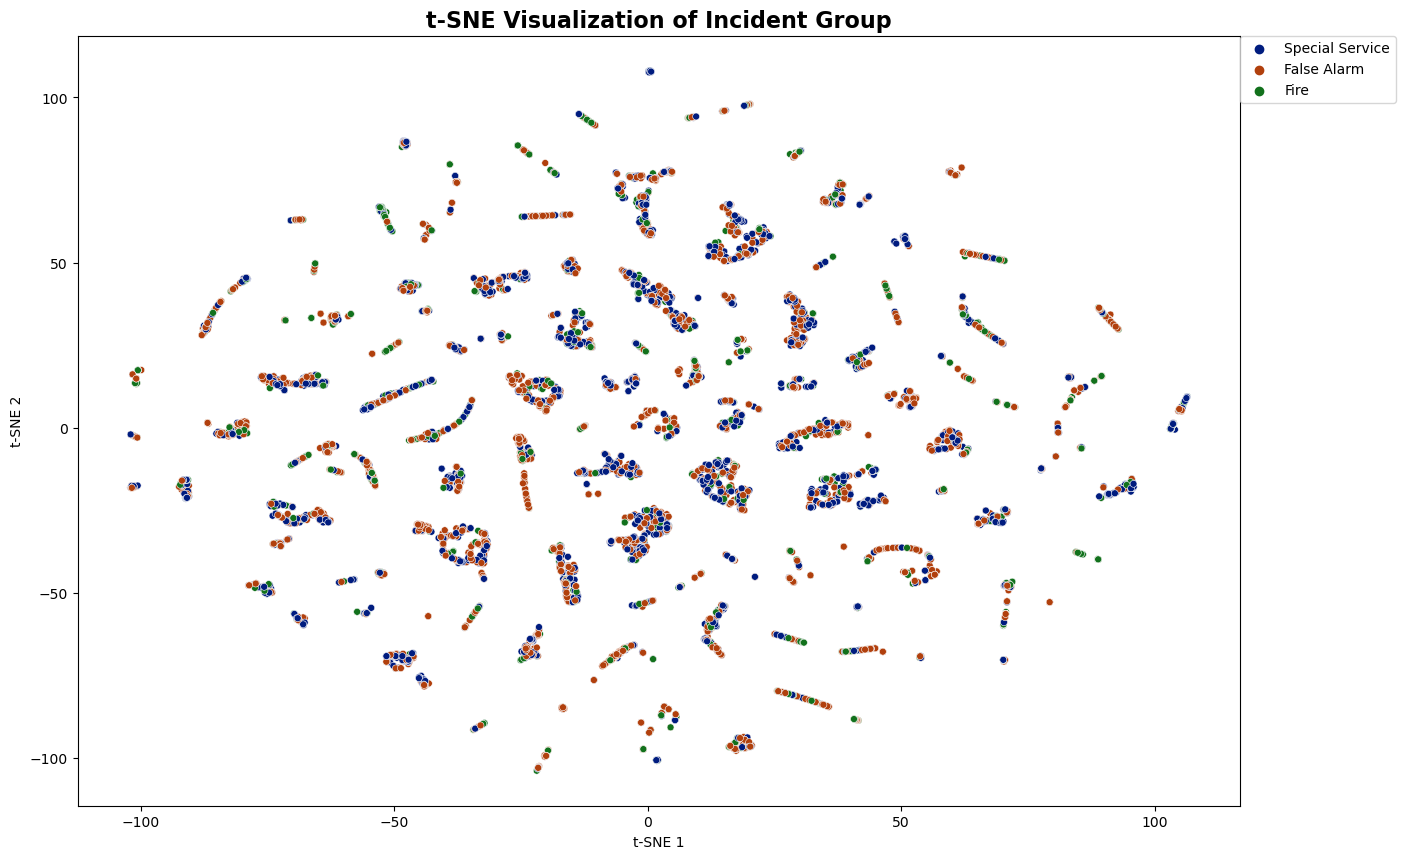

In [32]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = 't-SNE 1', y= 't-SNE 2', data = tsne_df, hue='label', ax = ax, s=25, palette = 'dark')
sns.color_palette("hls", 10)
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('t-SNE Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)

In [33]:
from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances

MACHINE_EPSILON = np.finfo(np.double).eps

In [34]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time.time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time.time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i


class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded


In [35]:
%%time

kendSDD=[]

import scipy
A=scipy.spatial.distance.pdist(X_df, metric='euclidean')
embedding = SDD()
X_SDD = embedding._fit(X_df, degrees_of_freedom=5)
B=scipy.spatial.distance.pdist(X_SDD, metric='euclidean')
kendSDD.append(scipy.stats.kendalltau(A, B))

Wall time: 4h 2min 4s


In [36]:
kendSDD

[KendalltauResult(correlation=0.002913878098897222, pvalue=1.029713791173265e-209)]

In [37]:
%%time
embedding=SDD()
X_SDD = embedding._fit(X_df,degrees_of_freedom=(kendSDD.index(max(kendSDD))+1))

Wall time: 3h 6min


In [38]:
sdd_df = pd.DataFrame({"X":X_SDD[:,0], "Y":X_SDD[:,1], "label":grouping_labels})
sdd_df.head()

X           Y            label
299579   -0.204014  -79.188202  Special Service
17083   -50.146446  -41.952614  Special Service
224861  -64.367279    3.356817  Special Service
253001  -17.872593  101.006721      False Alarm
303086 -125.172028  -22.525684      False Alarm

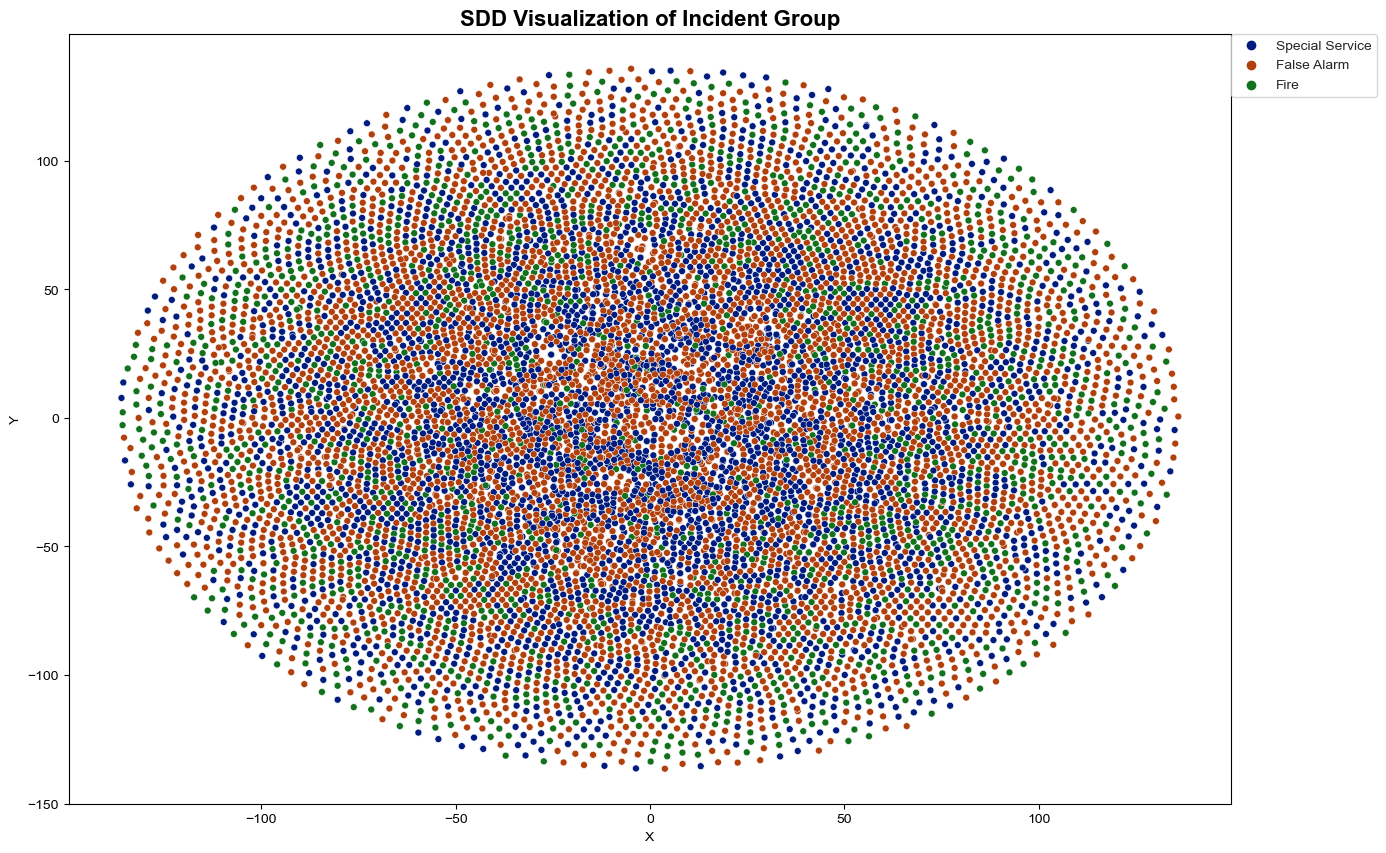

In [40]:
# Plotting the tsne data

fig, ax = plt.subplots(1, figsize=(15,10))
sns.scatterplot(x = sdd_df.X, y= sdd_df.Y, data = sdd_df, hue='label', ax = ax, s=25, palette = 'dark')
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')
# lim = (tsne_df.min()-5, tsne_df.max()+5)
ax.set_title('SDD Visualization of Incident Group', fontsize = 16, weight = 'bold')
ax.legend(bbox_to_anchor = (1,1), loc =2, borderaxespad = 0.0)